In [3]:
from recordclass import dataobject, enable_gc
import time
import gc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class Point(dataobject):
    x:int
    y:int
    __options__ = {'argsonly':True}

@enable_gc()
class PointGC(dataobject):
    x:int
    y:int
    __options__ = {'argsonly':True}

class PointSlots:
    __slots__ = 'x', 'y'
    
    def __init__(self, x, y):
        self.x = x
        self.y = y


2 <class '__main__.Point'>
2 <class '__main__.PointGC'>


In [5]:
def test_with_gc(N=1000000):
    gc.collect()
    t0 = time.time()
    for i in range(N):
        p = PointGC(i, i+1)
#     gc.collect()
    return time.time() - t0
        
def test_without_gc(N=1000000):
    gc.collect()
    t0 = time.time()
    for i in range(N):
        p = Point(i, i+1)
#     gc.collect()
    return time.time() - t0

def test_with_slots(N=1000000):
    gc.collect()
    t0 = time.time()
    for i in range(N):
        p = PointSlots(i, i+1)
#     gc.collect()
    return time.time() - t0
        

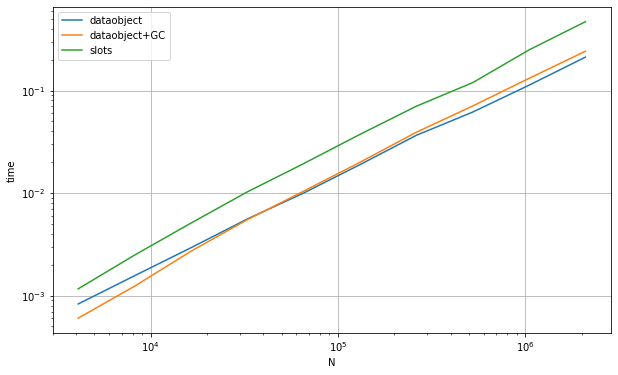

In [6]:
Ns = [2**n for n in range(12,22)]
Ms = list(range(12,22))
timings1 = np.array([test_without_gc(N) for N in Ns], 'd')
timings2 = np.array([test_with_gc(N) for N in Ns], 'd')
timings3 = np.array([test_with_slots(N) for N in Ns], 'd')
plt.figure(figsize=(10,6))
plt.loglog(Ns, timings1, label="dataobject")
plt.loglog(Ns, timings2, label="dataobject+GC")
plt.loglog(Ns, timings3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('time')
plt.minorticks_on()
plt.grid(1)
plt.savefig("objects_without_cyclic_GC1.jpg")
plt.show()

In [7]:
def test_with_gc(N=1000000):
    gc.collect()
    t0 = time.time()
    for i in range(N):
        p = PointGC(i, i+1)
    return time.time() - t0
        
def test_without_gc(N=1000000):
    gc.collect()
    t0 = time.time()
    for i in range(N):
        p = Point(i, i+1)
    return time.time() - t0

def test_with_slots(N=1000000):
    gc.collect()
    t0 = time.time()
    for i in range(N):
        p = PointSlots(i, i+1)
    return time.time() - t0


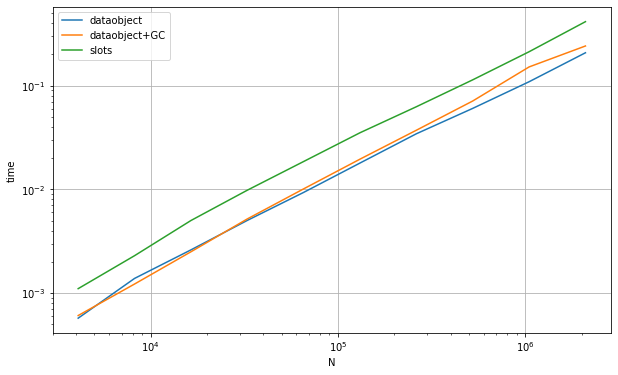

In [8]:
Ns = [2**n for n in range(12,22)]
Ms = list(range(12,22))
timings1 = [test_without_gc(N) for N in Ns]
timings2 = [test_with_gc(N) for N in Ns]
timings3 = [test_with_slots(N) for N in Ns]
plt.figure(figsize=(10,6))
plt.loglog(Ns, timings1, label="dataobject")
plt.loglog(Ns, timings2, label="dataobject+GC")
plt.loglog(Ns, timings3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('time')
plt.minorticks_on()
plt.grid(1)
plt.savefig("objects_without_cyclic_GC2.jpg")
plt.show()

In [9]:
def test_with_gc(N=1000000):
    gc.collect()
    gc.disable()
    t0 = time.time()
    for i in range(N):
        p = PointGC(i, i+1)
    dt = time.time() - t0
    gc.enable()
    return dt
        
def test_without_gc(N=1000000):
    gc.collect()
    gc.disable()
    t0 = time.time()
    for i in range(N):
        p = Point(i, i+1)
    dt = time.time() - t0
    gc.enable()
    return dt

def test_with_slots(N=1000000):
    gc.collect()
    gc.disable()
    t0 = time.time()
    for i in range(N):
        p = PointSlots(i, i+1)
    dt = time.time() - t0
    gc.enable()
    return dt


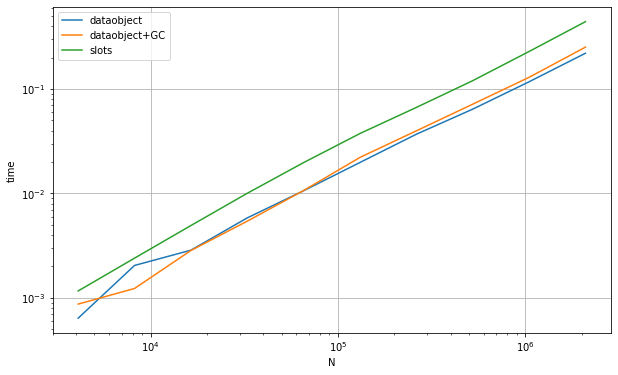

In [10]:
Ns = [2**n for n in range(12,22)]
Ms = list(range(12,22))
timings1 = np.array([test_without_gc(N) for N in Ns], 'd')
timings2 = np.array([test_with_gc(N) for N in Ns], 'd')
timings3 = np.array([test_with_slots(N) for N in Ns], 'd')
plt.figure(figsize=(10,6))
plt.loglog(Ns, timings1, label="dataobject")
plt.loglog(Ns, timings2, label="dataobject+GC")
plt.loglog(Ns, timings3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('time')
plt.minorticks_on()
plt.grid(1)
plt.savefig("objects_without_cyclic_GC3.jpg")
plt.show()

In [11]:
import tracemalloc
class Tracer:
    def __enter__(self):
        if tracemalloc.is_tracing():
            raise ValueError('nesting tracemalloc is not allowed')
        self.allocated = None
        tracemalloc.start()
        return self
    def __exit__(self, exc_type, exc_value, exc_traceback):
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        self.allocated = current

In [12]:
def test_with_gc(N=1000000):
    for i in range(N):
        p = PointGC(i, i+1)
        
def test_without_gc(N=1000000):
    for i in range(N):
        p = Point(i, i+1)

def test_with_slots(N=1000000):
    for i in range(N):
        p = PointSlots(i, i+1)


In [13]:
def mtrace(Ns, func):
    gc.enable()
    gc.collect()
    gc.collect()
    gc.collect()
    Ds = []
    for N in Ns:
        with Tracer() as t:
            func(N)
        Ds.append(t.allocated)
    return Ds

[1144, 167, 0, 439, 843, 115, 0, 0, 0, 0]
[680, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[680, 0, 0, 0, 0, 0, 0, 0, 0, 0]


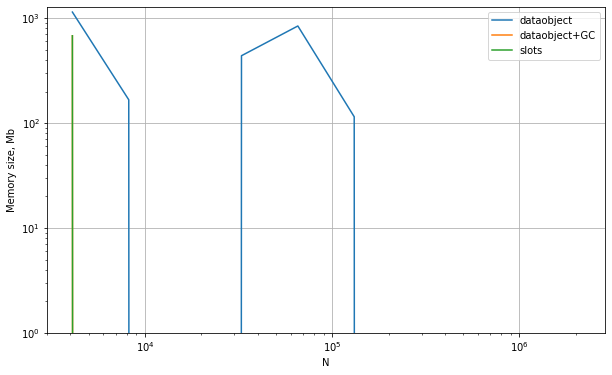

In [14]:
Ns = [2**n for n in range(12,22)]
Ds1 = mtrace(Ns, test_without_gc)
Ds2 = mtrace(Ns, test_with_gc)
Ds3 = mtrace(Ns, test_with_slots)
print(Ds1)
print(Ds2)
print(Ds3)

plt.figure(figsize=(10,6))
plt.loglog(Ns, Ds1, label="dataobject")
plt.loglog(Ns, Ds2, label="dataobject+GC")
plt.loglog(Ns, Ds3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('Memory size, Mb')
plt.minorticks_on()
plt.grid(1)
y1, y2 = plt.ylim()
plt.ylim(1, y2)
plt.savefig("objects_without_cyclic_GC4.jpg")
plt.show()